In [2]:
# I worked on google colab due to training of the models so if you want to work locally u shoudl to commment/uncomment some imports etc. which are always comented with "IMPORTANT#!!!!"
#IMPORTANT!!!! COLAB SPECIFIC INSTALLS IMPORTS WHICH SHOULD BE COMMENTED IF WORKING LOCALLY
from google.colab import drive # GOOGLE COLAB ONLY, COMMENT OTHERWISE
drive.mount('/content/drive') #COMMENT IF NOT GOOGLE COLAB!!!!
!pip install grad-cam -q # IF WORKING OUTSIDE OF COLAB IT SHOULD BE COMMNETED (unless not installed)






# core libs
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# pztorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# xai
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.neural_network import MLPClassifier
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2


# for reporoducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("libs imported")

# useful later on due to the format conversion of data
class GrayscaleToRgb:
    """grayscale image to RGB by repeating the channel"""
    def __call__(self, x):
        return x.repeat(3, 1, 1) if x.size(0) == 1 else x

print("'GrayscaleToRgb' wroking")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 834.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# THE UNCOMENTED PATH IS FOR GOOGLE DRIVE, IF YOU WORK LOCALLY YOU SHOULD SPECIFY THE DIR OF THE PROEJCT (directory with the 'test' and 'training' folders (and the jupyternotebook we work with rn))
BASE_DIR = '/content/drive/MyDrive/IS' #IMPORTANT!!!!SPECIFY THE DIR OF THE PROEJCT (directory with the 'test' and 'training' folders (and the jupyternotebook we work with rn)
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')





# model and data params
IMAGE_SIZE = 224
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# set to 0 if slow pc
NUM_WORKERS = 2

print(f"device: {DEVICE}")

device: cpu


In [4]:
# data analysis
train_normal_dir = os.path.join(TRAIN_DIR, 'NORMAL')
train_pneumonia_dir = os.path.join(TRAIN_DIR, 'PNEUMONIA')

valid_extensions = ('.jpeg', '.jpg', '.png') #since I don't remeber if all the files had the same extension
num_normal_samples = len([f for f in os.listdir(train_normal_dir) if f.lower().endswith(valid_extensions)])
num_pneumonia_samples = len([f for f in os.listdir(train_pneumonia_dir) if f.lower().endswith(valid_extensions)])
total_train_samples = num_normal_samples + num_pneumonia_samples

print(f"{num_normal_samples} 'normal' images in the training set")
print(f"{num_pneumonia_samples} 'pneumonia' images in the training set")
print(f"total training samples: {total_train_samples}")

# calculate weight for the positive class (Pneumonia)
pos_weight_value = num_normal_samples / num_pneumonia_samples
pos_weight = torch.tensor([pos_weight_value], device=DEVICE)

print(f"\n class imbalance ratio: {num_pneumonia_samples/num_normal_samples:.2f}")
print(f"'pos_weight' for BCEWithLogitsLoss: {pos_weight.item():.4f}")

1349 'normal' images in the training set
3883 'pneumonia' images in the training set
total training samples: 5232

 class imbalance ratio: 2.88
'pos_weight' for BCEWithLogitsLoss: 0.3474


In [5]:
# ormalization stats for ImageNet, as required by pre-trained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# transforms for the training set
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    GrayscaleToRgb(), # Using the previouslz defined custom class here
    normalize
])

# transforms for the test set
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    GrayscaleToRgb(),
    normalize
])

print("train and test transforms created successfully")

train and test transforms created successfully


In [6]:
#custam PyTorch Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []

        normal_dir = os.path.join(image_dir, 'NORMAL')
        pneumonia_dir = os.path.join(image_dir, 'PNEUMONIA')

        valid_extensions = ('.jpeg', '.jpg', '.png')

        for fname in os.listdir(normal_dir):
            if fname.lower().endswith(valid_extensions):
                self.samples.append((os.path.join(normal_dir, fname), 0))

        for fname in os.listdir(pneumonia_dir):
            if fname.lower().endswith(valid_extensions):
                self.samples.append((os.path.join(pneumonia_dir, fname), 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]

        try:
            #open as L to handle single-channel images, which will be converted by GrayscaleToRgb
            image = Image.open(image_path).convert('L')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(3, IMAGE_SIZE, IMAGE_SIZE), torch.tensor(0.0, dtype=torch.float32)

        return image, torch.tensor(label, dtype=torch.float32)


train_dataset = ChestXRayDataset(image_dir=TRAIN_DIR, transform=train_transforms)
test_dataset = ChestXRayDataset(image_dir=TEST_DIR, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"train: {len(train_dataset)} samples")
print(f"test: {len(test_dataset)} samples")

train: 5232 samples
test: 624 samples


In [7]:
#splitting train
from torch.utils.data import random_split

full_train_dataset = ChestXRayDataset(image_dir=TRAIN_DIR, transform=train_transforms)
test_dataset = ChestXRayDataset(image_dir=TEST_DIR, transform=test_transforms)

# 85% for train 15% for val
val_size = int(len(full_train_dataset) * 0.15)
train_size = len(full_train_dataset) - val_size

# splitting train and val
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

print(f"initial training set: {len(full_train_dataset)}")
print(f"training subset:   {len(train_subset)}")
print(f"validation subset : {len(val_subset)}")
print(f"test set:          {len(test_dataset)}")


# updating DataLoaders
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

initial training set: 5232
training subset:   4448
validation subset : 784
test set:          624


In [8]:
def train_and_validate_model(model, model_name, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=10):
    print(f"starting training for {model_name}")
    model.to(device)

    best_f1_score = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        # training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        #validation
        model.eval()
        running_loss = 0.0
        val_preds_all, val_labels_all = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten()
                val_preds_all.extend(preds)
                val_labels_all.extend(labels.cpu().numpy().flatten())

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_f1 = f1_score(val_labels_all, val_preds_all, zero_division=0)
        history['val_loss'].append(epoch_val_loss)
        history['val_f1'].append(val_f1)

        scheduler.step(val_f1) # scheduler on F1 val score

        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"epoch {epoch+1}/{num_epochs} [{epoch_duration:.1f}s] | train Loss: {epoch_train_loss:.4f} | val Loss: {epoch_val_loss:.4f} | val F1: {val_f1:.4f}")

        if val_f1 > best_f1_score:
            print(f"Val F1 improved from {best_f1_score:.4f} to {val_f1:.4f}. Saving model weights.")
            best_f1_score = val_f1
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, f'{model_name}_best_weights.pth')

    print(f"Finished traininig {model_name}. Best val F1: {best_f1_score:.4f}")
    model.load_state_dict(torch.load(f'{model_name}_best_weights.pth'))
    return model, history

In [ ]:
#training DenseNet121
model_densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# freezing all params
for param in model_densenet.parameters():
    param.requires_grad = False

# replacing the final classifier layer
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, 1)
model_densenet = model_densenet.to(DEVICE) #before constructing the optmizer

# optimizerfor the new layer and criterion
optimizer_densenet = optim.Adam(model_densenet.classifier.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# scheduler to reduce LR when performance plateaus
scheduler_densenet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_densenet, mode='max', factor=0.1, patience=2, verbose=True)

# training
trained_densenet, history_densenet = train_and_validate_model(
    model=model_densenet,
    model_name="DenseNet121",
    criterion=criterion,
    optimizer=optimizer_densenet,
    scheduler=scheduler_densenet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    num_epochs=10
)

--- Starting Training for DenseNet121 ---
Epoch 1/10 [77.2s] | Train Loss: 0.2595 | Val Loss: 0.1984 | Val F1: 0.9426
   -> Val F1 improved from 0.0000 to 0.9426. Saving model weights.
Epoch 2/10 [68.4s] | Train Loss: 0.1697 | Val Loss: 0.1504 | Val F1: 0.9269
Epoch 3/10 [68.9s] | Train Loss: 0.1388 | Val Loss: 0.1292 | Val F1: 0.9400
Epoch 4/10 [69.0s] | Train Loss: 0.1261 | Val Loss: 0.1232 | Val F1: 0.9336
Epoch 5/10 [68.6s] | Train Loss: 0.1172 | Val Loss: 0.1167 | Val F1: 0.9380
Epoch 6/10 [68.4s] | Train Loss: 0.1169 | Val Loss: 0.1203 | Val F1: 0.9360
Epoch 7/10 [68.6s] | Train Loss: 0.1187 | Val Loss: 0.1159 | Val F1: 0.9431
   -> Val F1 improved from 0.9426 to 0.9431. Saving model weights.
Epoch 8/10 [68.3s] | Train Loss: 0.1110 | Val Loss: 0.1082 | Val F1: 0.9468
   -> Val F1 improved from 0.9431 to 0.9468. Saving model weights.
Epoch 9/10 [68.3s] | Train Loss: 0.1126 | Val Loss: 0.1122 | Val F1: 0.9461
Epoch 10/10 [68.8s] | Train Loss: 0.1170 | Val Loss: 0.1122 | Val F1: 0.9

In [ ]:
print("\nfine-tuning for DenseNet121")

# unfreezing the last dense block and the final normalization layer
for param in model_densenet.features.denseblock4.parameters():
    param.requires_grad = True
for param in model_densenet.features.norm5.parameters():
    param.requires_grad = True

# new optimizer with very low learning rate
optimizer_densenet_finetune = optim.Adam(
    filter(lambda p: p.requires_grad, model_densenet.parameters()),
    lr=0.0001
)

scheduler_densenet_finetune = optim.lr_scheduler.ReduceLROnPlateau(optimizer_densenet_finetune, mode='max', factor=0.1, patience=2, verbose=True)

trained_densenet, history_densenet_finetune = train_and_validate_model(
    model=model_densenet,
    model_name="DenseNet121_FineTuned", # new weights
    criterion=criterion,
    optimizer=optimizer_densenet_finetune,
    scheduler=scheduler_densenet_finetune,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    num_epochs=5 # fine-tuning for fewer epochs
)


Fine-Tuning for DenseNet121
--- Starting Training for DenseNet121_FineTuned ---
Epoch 1/5 [80.8s] | Train Loss: 0.0803 | Val Loss: 0.0630 | Val F1: 0.9625
   -> Val F1 improved from 0.0000 to 0.9625. Saving model weights.
Epoch 2/5 [80.3s] | Train Loss: 0.0499 | Val Loss: 0.0539 | Val F1: 0.9669
   -> Val F1 improved from 0.9625 to 0.9669. Saving model weights.
Epoch 3/5 [88.7s] | Train Loss: 0.0443 | Val Loss: 0.0389 | Val F1: 0.9806
   -> Val F1 improved from 0.9669 to 0.9806. Saving model weights.
Epoch 4/5 [82.7s] | Train Loss: 0.0400 | Val Loss: 0.0470 | Val F1: 0.9733
Epoch 5/5 [81.6s] | Train Loss: 0.0342 | Val Loss: 0.0393 | Val F1: 0.9770
--- Finished Training for DenseNet121_FineTuned. Best Val F1: 0.9806 ---


In [ ]:
#training ResNet50
model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

#freezjn all params
for param in model_resnet.parameters():
    param.requires_grad = False

#replacing the final fully connected layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)

model_resnet = model_resnet.to(DEVICE)
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)
scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='max', factor=0.1, patience=2, verbose=True)


# training the moedl
trained_resnet, history_resnet = train_and_validate_model(
    model=model_resnet,
    model_name="ResNet50",
    criterion=criterion,
    optimizer=optimizer_resnet,
    scheduler=scheduler_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    num_epochs=10
)

--- Starting Training for ResNet50 ---
Epoch 1/10 [67.4s] | Train Loss: 0.2541 | Val Loss: 0.2157 | Val F1: 0.9228
   -> Val F1 improved from 0.0000 to 0.9228. Saving model weights.
Epoch 2/10 [79.5s] | Train Loss: 0.1723 | Val Loss: 0.1591 | Val F1: 0.8964
Epoch 3/10 [77.1s] | Train Loss: 0.1485 | Val Loss: 0.1449 | Val F1: 0.9069
Epoch 4/10 [79.5s] | Train Loss: 0.1346 | Val Loss: 0.1403 | Val F1: 0.9055
Epoch 5/10 [81.7s] | Train Loss: 0.1282 | Val Loss: 0.1306 | Val F1: 0.9143
Epoch 6/10 [85.3s] | Train Loss: 0.1268 | Val Loss: 0.1234 | Val F1: 0.9195
Epoch 7/10 [77.5s] | Train Loss: 0.1287 | Val Loss: 0.1283 | Val F1: 0.9199
Epoch 8/10 [82.7s] | Train Loss: 0.1256 | Val Loss: 0.1339 | Val F1: 0.9130
Epoch 9/10 [75.6s] | Train Loss: 0.1285 | Val Loss: 0.1359 | Val F1: 0.9111
Epoch 10/10 [80.1s] | Train Loss: 0.1284 | Val Loss: 0.1354 | Val F1: 0.9174
--- Finished Training for ResNet50. Best Val F1: 0.9228 ---


In [ ]:
# feature extraction
def extract_features(loader, model, device):
    print("Extracting features...")
    model.to(device)
    model.eval()

    #removing the final classification layer
    if isinstance(model, models.ResNet):
        feature_extractor = nn.Sequential(*list(model.children())[:-1])
    elif isinstance(model, models.DenseNet):
        #the features are extracted, then passed through the classifier, we want the output of the features part
        feature_extractor = model.features
    else:
        raise TypeError("not supported for feature extraction")

    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)
            # for densenet, we need to apply pooling and flatten
            if isinstance(model, models.DenseNet):
                 out = nn.functional.relu(feats, inplace=True)
                 out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
                 feats = torch.flatten(out, 1)
            else: # for ResNet
                feats = torch.flatten(feats, 1)

            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    print("Feature extraction complete.")
    return features, labels

# using the best trained model (DenseNet121) as the extractor
#using the original train/test datasets without augmentation for feature extraction
train_dataset_no_aug = ChestXRayDataset(image_dir=TRAIN_DIR, transform=test_transforms)
train_loader_no_aug = DataLoader(dataset=train_dataset_no_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_features, train_labels_feat = extract_features(train_loader_no_aug, trained_densenet, DEVICE)
test_features, test_labels_feat = extract_features(test_loader, trained_densenet, DEVICE)

print(f"\nShape of extracted training features: {train_features.shape}")
print(f"Shape of extracted test features: {test_features.shape}")


--- Extracting features using the trained DenseNet121 ---
Extracting features...
Feature extraction complete.
Extracting features...
Feature extraction complete.

Shape of extracted training features: (5232, 1024)
Shape of extracted test features: (624, 1024)


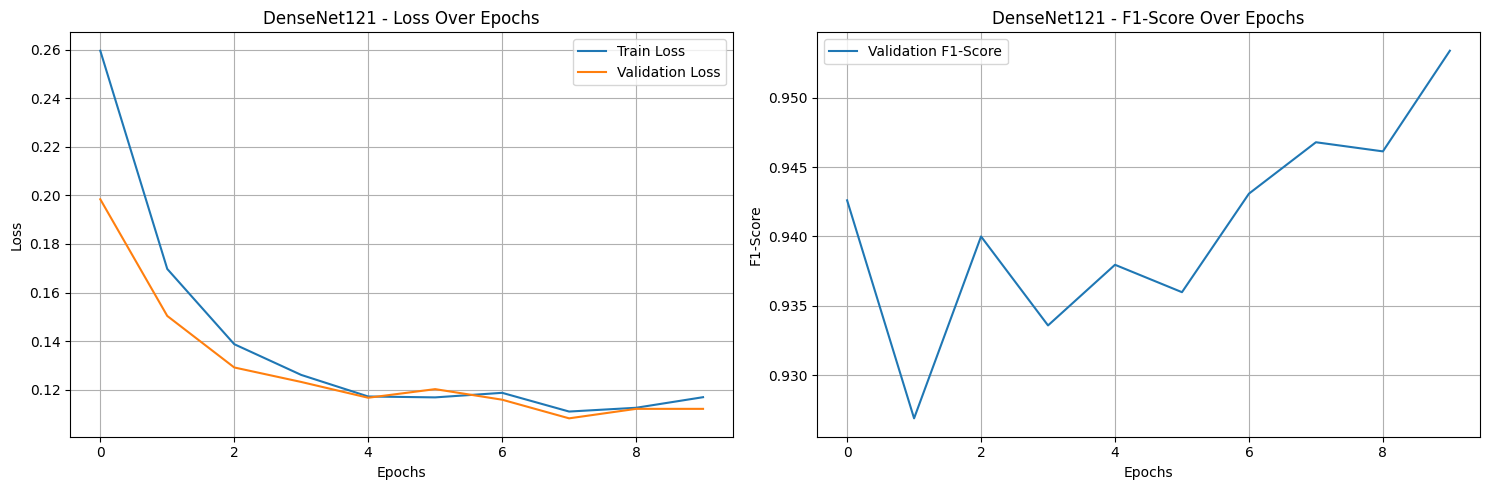

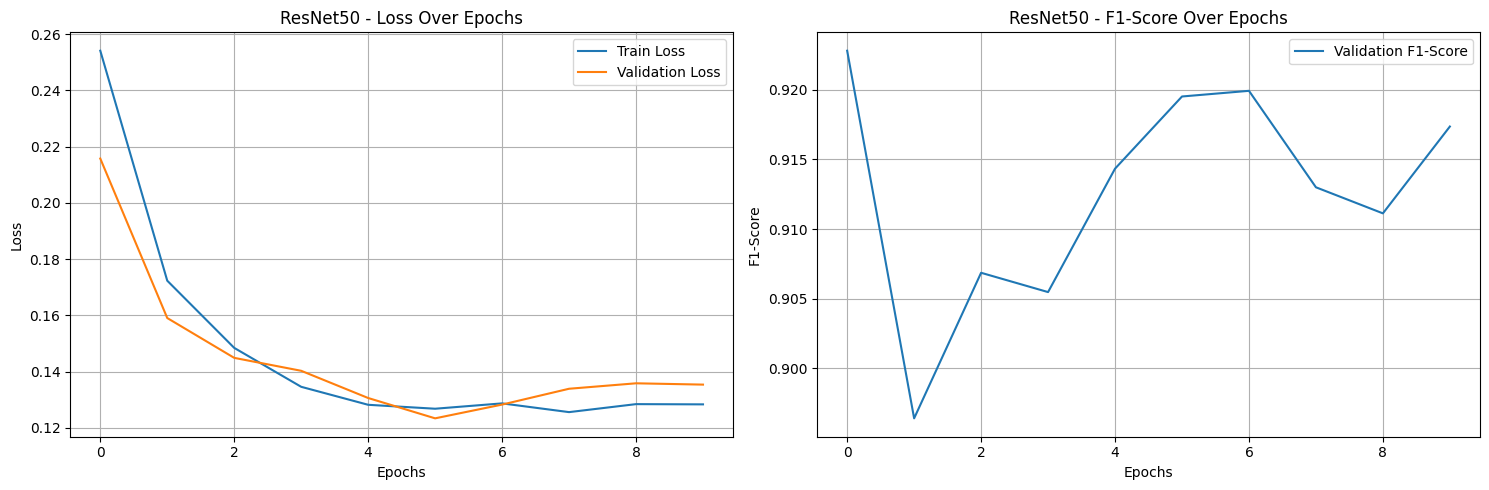

In [ ]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['val_f1'], label='Validation F1-Score')
    ax2.set_title(f'{model_name} - F1-Score Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1-Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_densenet, "DenseNet121")
plot_history(history_resnet, "ResNet50")

In [ ]:
#training MLP on extracted features
#labels are floats (0.0, 1.0), so we need to convert them to int for sklearn
train_labels_feat_int = train_labels_feat.astype(int)

mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=seed,
    verbose=True,
    early_stopping=True,
    n_iter_no_change=20 #stop if validation score doesn't improve for 20 iterations
)

print("Training MLP...")
mlp_classifier.fit(train_features, train_labels_feat_int)


--- Training a classical MLP on extracted features ---
Training MLP...
Iteration 1, loss = 0.40451680
Validation score: 0.937023
Iteration 2, loss = 0.14175793
Validation score: 0.944656
Iteration 3, loss = 0.11083312
Validation score: 0.946565
Iteration 4, loss = 0.09936826
Validation score: 0.952290
Iteration 5, loss = 0.08365521
Validation score: 0.946565
Iteration 6, loss = 0.07397777
Validation score: 0.958015
Iteration 7, loss = 0.07543614
Validation score: 0.959924
Iteration 8, loss = 0.06401357
Validation score: 0.959924
Iteration 9, loss = 0.05322614
Validation score: 0.959924
Iteration 10, loss = 0.05197440
Validation score: 0.961832
Iteration 11, loss = 0.04013304
Validation score: 0.958015
Iteration 12, loss = 0.03650092
Validation score: 0.958015
Iteration 13, loss = 0.03452254
Validation score: 0.961832
Iteration 14, loss = 0.02840489
Validation score: 0.967557
Iteration 15, loss = 0.03366461
Validation score: 0.959924
Iteration 16, loss = 0.02512861
Validation score: 0.

MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 128), max_iter=500,
              n_iter_no_change=20, random_state=42, verbose=True)

In [ ]:
#final results
def evaluate_pytorch_model(model, loader, device):
    """Generates a classification report for a PyTorch model."""
    model.to(device)
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten().astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten().astype(int))
    return classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia'], output_dict=True)

print("--- Evaluating all models on the Test Set ---")
resnet_report = evaluate_pytorch_model(trained_resnet, test_loader, DEVICE)
densenet_report = evaluate_pytorch_model(trained_densenet, test_loader, DEVICE)

mlp_preds = mlp_classifier.predict(test_features)
mlp_report = classification_report(test_labels_feat.astype(int), mlp_preds, target_names=['Normal', 'Pneumonia'], output_dict=True)

#dictionary to hold the results
results_dict = {
    "DenseNet121": densenet_report['weighted avg'],
    "ResNet50": resnet_report['weighted avg'],
    "MLP on Features": mlp_report['weighted avg'],
}

#tge summary df
df_results = pd.DataFrame(results_dict).T
#clean up support column if it exists
if 'support' in df_results.columns:
    df_results['support'] = df_results['support'].astype(int)

print("\nModel Performance Comparison (Weighted Avg)")
print(df_results[['precision', 'recall', 'f1-score', 'support']])

--- Evaluating all models on the Test Set ---

--- Model Performance Comparison (Weighted Avg) ---
                 precision    recall  f1-score  support
DenseNet121       0.892257  0.887821  0.884995      624
ResNet50          0.853675  0.850962  0.851815      624
MLP on Features   0.843480  0.804487  0.784928      624


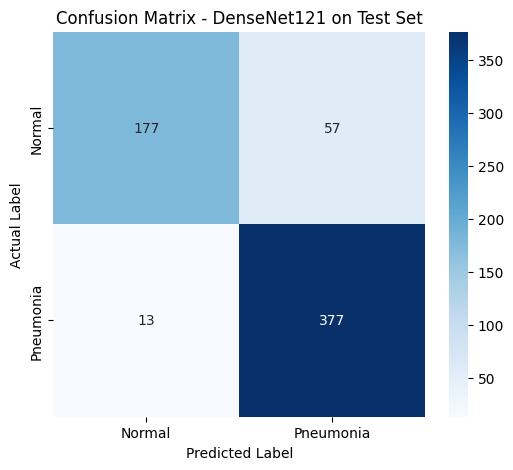

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#predictions for the best model i.e. DenseNet121
model = trained_densenet
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten().astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy().flatten().astype(int))

# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - DenseNet121 on Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Generating Grad-CAM explanation ---


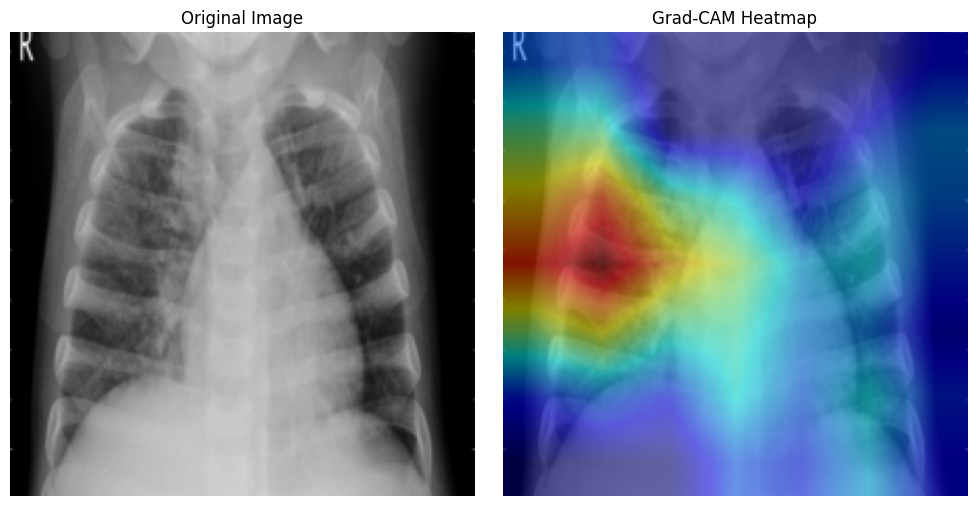

Grad-CAM image saved as 'grad_cam_example.png'


In [ ]:
#xai with Grad-CAM, we'll use the best performing model, DenseNet121
model_for_cam = trained_densenet
target_layers = [model_for_cam.features.denseblock4]

#original image
vis_dataset = ChestXRayDataset(image_dir=TEST_DIR, transform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
]))

#pneumonia image
pneumonia_indices = [i for i, (img, label) in enumerate(vis_dataset) if label == 1]
sample_idx = pneumonia_indices[15] #some sample

#normalized tensor for the model and the un-normalized for visualization
input_tensor_for_model, _ = test_dataset[sample_idx] # This one has all transforms (incl normalization)
input_tensor_for_model = input_tensor_for_model.unsqueeze(0).to(DEVICE)

rgb_img_for_vis, _ = vis_dataset[sample_idx] # This one is just resized
# Convert the grayscale tensor to a 3-channel numpy array for visualization
rgb_img_for_vis = rgb_img_for_vis.repeat(3, 1, 1).permute(1, 2, 0).numpy()


#create the CAM object and run it
cam = GradCAM(model=model_for_cam, target_layers=target_layers)

#for a binary model with one output neuron, the target class index is always 0.
targets = [ClassifierOutputTarget(0)]

grayscale_cam = cam(input_tensor=input_tensor_for_model, targets=targets)
grayscale_cam = grayscale_cam[0, :] # Extract the CAM for the first (and only) image in the batch

# use_rgb=True is important as rgb_img_for_vis is in RGB format
visualization = show_cam_on_image(rgb_img_for_vis, grayscale_cam, use_rgb=True)

#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb_img_for_vis)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(visualization)
axes[1].set_title("Grad-CAM Heatmap")
axes[1].axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite('grad_cam_example.png', cv2.cvtColor((visualization * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print("Grad-CAM image saved as 'grad_cam_example.png'")